In [1]:
import os, cv2, random, json
import numpy as np
import pandas as pd
np.random.seed(2016)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential, Model
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Dense, Activation
from keras.layers import merge, Convolution1D, BatchNormalization, Reshape, Permute
from keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD, Adadelta
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.regularizers import l2
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
ROWS = 120
COLS = 320
CHANNELS = 3
DIR = 'data/IMG/'

## Parsing the Data Log

First, I load the data_log.csv into pandas and extract the center image paths and steering angle labels. 

In [3]:
data = pd.read_csv('data/driving_log.csv', header=None, 
                   names=['center', 'left', 'right', 'angle', 'throttle', 'break', 'speed'])
print(data.ix[0].center)
data.sample()

/home/jeffd23/data/sdc/projects/behavioral-cloning/data/IMG/center_2016_12_23_13_42_01_956.jpg


,center,left,right,angle,throttle,break,speed
2634,/home/jeffd23/data/sdc/projects/behavioral-clo...,/home/jeffd23/data/sdc/projects/behavioral-cl...,/home/jeffd23/data/sdc/projects/behavioral-cl...,0.938424,0.0,0,7.242576


In [4]:
def img_id(path):
    return path.split('/IMG/')[1]
image_paths = data.center.apply(img_id).values.tolist()
image_paths[:5]

['center_2016_12_23_13_42_01_956.jpg',
 'center_2016_12_23_13_42_02_058.jpg',
 'center_2016_12_23_13_42_02_159.jpg',
 'center_2016_12_23_13_42_02_260.jpg',
 'center_2016_12_23_13_42_02_362.jpg']

In [5]:
# y_all = data[['angle', 'throttle']].values
y_all = data.angle.values
n_samples = y_all.shape[0]
print("Training Model with {} Samples".format(n_samples))

Training Model with 3141 Samples


## Reading and Preprocessing the Images with OpenCV

In [6]:
def read_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = img[40:160, 0:320] ## Cropping top section of image, just useless noise
#     img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#     img = np.expand_dims(img, axis=2)
    return img[:,:,::-1]

X_all = np.ndarray((n_samples, ROWS, COLS, CHANNELS), dtype=np.uint8)

for i, path in enumerate(image_paths):
    DIR+path
    img = read_image(DIR+path)
    X_all[i] = img
    
print(X_all.shape)

(3141, 120, 320, 3)


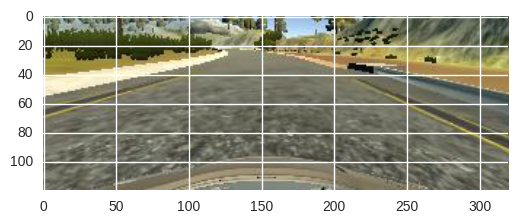

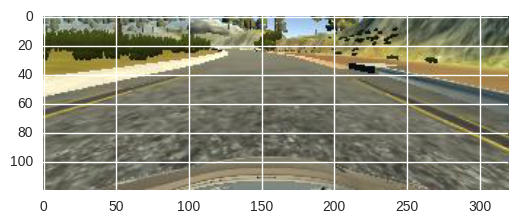

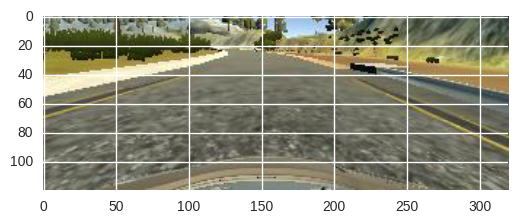

In [7]:
for img in X_all[:3]:
    plt.imshow(img)
    plt.show()

## Building a Convnet in Keras

1. Split the data in train/test sets.
2. Build a keras model for regression. 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.20, random_state=23)

In [9]:
def fit_gen(data, batch_size):
    while 1:
        x = np.ndarray((batch_size, ROWS, COLS, CHANNELS), dtype=np.uint8)
        y = np.zeros(batch_size)
        i=0
        for line in data.iterrows():
            path = line[1].center.split('/IMG/')[1]
            x[i] = read_image(DIR+path)
            y[i] = line[1].angle
            i+=1
            if i == batch_size:
                i=0
                yield (x, y)
                x = np.ndarray((batch_size, ROWS, COLS, CHANNELS), dtype=np.uint8)
                y = np.zeros(batch_size)



In [10]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def get_model():
    lr = 0.0001
    weight_init='glorot_normal'
    opt = RMSprop(lr)
    loss = 'mean_squared_error'

    model = Sequential()
    
    model.add(BatchNormalization(mode=2, axis=1, input_shape=(ROWS, COLS, CHANNELS)))
    model.add(Convolution2D(3, 3, 3, init=weight_init, border_mode='valid', activation='relu', input_shape=(ROWS, COLS, CHANNELS)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(9, 3, 3, init=weight_init, border_mode='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(18, 3, 3, init=weight_init, border_mode='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(32, 3, 3, init=weight_init, border_mode='valid',  activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(80, activation='relu', init=weight_init))
#     model.add(Dropout(0.5))
    
    model.add(Dense(15, activation='relu', init=weight_init))
    
    model.add(Dropout(0.25))
    model.add(Dense(1, init=weight_init, activation='linear'))

    model.compile(optimizer=opt, loss=loss)

    return model
    
model = get_model()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNormal(None, 120, 320, 3)   240         batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 118, 318, 3)   84          batchnormalization_1[0][0]       
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 59, 159, 3)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 57, 157, 9)    252         maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [11]:
nb_epoch = 30
batch_size = 64

### Creating Validation Data
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.20, random_state=23)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1, mode='auto')   
save_weights = ModelCheckpoint('new_model.h5', monitor='val_loss', save_best_only=True)

model.fit_generator(fit_gen(data, 32),
        samples_per_epoch=data.shape[0], nb_epoch=nb_epoch, 
        validation_data=(X_test, y_test), callbacks=[save_weights, early_stopping])
        

model.fit(X_all, y_all, batch_size=batch_size, nb_epoch=nb_epoch,
          validation_data=(X_test, y_test), verbose=1, shuffle=True, callbacks=[save_weights, early_stopping])


preds = model.predict(X_test, verbose=1)

print( "Test MSE: {}".format(mean_squared_error(y_test, preds)))
print( "Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test, preds))))

Train on 3141 samples, validate on 629 samples
Epoch 1/30
3141/3141 [==============================] - 4s - loss: 0.0931 - val_loss: 0.0714
Epoch 2/30
3141/3141 [==============================] - 3s - loss: 0.0675 - val_loss: 0.0515
Epoch 3/30
3141/3141 [==============================] - 3s - loss: 0.0605 - val_loss: 0.0705
Epoch 4/30
3141/3141 [==============================] - 3s - loss: 0.0587 - val_loss: 0.0511
Epoch 5/30
3141/3141 [==============================] - 3s - loss: 0.0566 - val_loss: 0.0438
Epoch 6/30
3141/3141 [==============================] - 3s - loss: 0.0536 - val_loss: 0.0440
Epoch 7/30
3141/3141 [==============================] - 3s - loss: 0.0532 - val_loss: 0.0474
Epoch 8/30
3141/3141 [==============================] - 3s - loss: 0.0520 - val_loss: 0.0417
Epoch 9/30
3141/3141 [==============================] - 3s - loss: 0.0520 - val_loss: 0.0488
Epoch 10/30
3141/3141 [==============================] - 3s - loss: 0.0512 - val_loss: 0.0479
Epoch 11/30
3141/3141 

In [12]:
js = model.to_json()
with open('model.json', 'w') as outfile:
    json.dump(js, outfile)